In [2]:
import os
import pickle
from pprint import pprint
import datetime
import numpy as np
from matplotlib import pyplot as plt
import torch
from structure_utils import *

dirname = 'TDMLossToZero'

losses = []
with open(dirname+'/loss.txt', 'r') as f:
    for iteration in f:
        losses.append([float(term) for term in iteration.split()])
losses = np.array(losses)
# print(losses)
N_iters = losses.shape[0]

# Plot total loss
plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), np.sum(losses, axis=1), label='Total')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.show()

# Plot respective losses
colors = ['r', 'g', 'y', 'k']
for i in range(4):
    plt.plot(range(N_iters), losses[:, i], colors[i], label='Loss' + str(i+1))

plt.legend(loc='upper right')
plt.show()

# Plot loss1 separately
plt.figure()
plt.title('Loss1')
plt.plot(range(N_iters), losses[:, 0])
plt.show()


<Figure size 2000x1500 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [3]:
# Plot train and validation loss in the same figure

# Get validation losses
val = []
with open(dirname + '/val_loss.txt', 'r') as f:
    for iteration in f:
        val.append([float(term) for term in iteration.split()])
val = np.array(val)

# Plot
plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), np.sum(losses, axis=1), label='Train')
valx = val[:, 0]  # The first column of val is the iteration numbers
plt.plot(valx, np.sum(val[:, 1:], axis=1), label='Validation')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train and validation loss for the RRNN')
plt.show()

# Next do this for an actual GRU model.


FileNotFoundError: [Errno 2] No such file or directory: 'TDMLossToZero/val_loss.txt'

In [ ]:
# Training and validation accuracy

val = []
with open(dirname + '/val_acc.txt', 'r') as f:
    for iteration in f:
        val.append([float(term) for term in iteration.split()])
val = np.array(val)

train = []
with open(dirname + '/train_acc.txt', 'r') as f:
    for iteration in f:
        train.append([float(term) for term in iteration.split()])
train = np.array(train)

# Training accuracy here is the average of the last V training examples, 
# where V is the size of the validation set.
val_size = 500
for i in reversed(range(train.shape[0])):
    train[i] = np.mean(train[i-val_size:i])

plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), train, label='Train')
plt.plot(val[:, 0], val[:, 1:], label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.legend(loc='upper right')
plt.show()


In [19]:
# Display hyperparameters and run information

params = pickle.load(open(dirname+'/hyperparameters.pkl', 'rb'))
pprint(params)

runtime = pickle.load(open(dirname+'/runtime.pkl', 'rb'))
print('\nRuntime: ' + str(datetime.timedelta(seconds=runtime)))

{'batch_size': 1,
 'debug': True,
 'epochs': 1000000,
 'epochs_per_checkpoint': 10000,
 'lambdas': (0, 0, 0, 1),
 'learning_rate': 0.01,
 'loss2_margin': 1,
 'multiplier': 1,
 'n_processes': 1,
 'nb_data': 1,
 'optimizer': 'adam',
 'samples': 10,
 'scoring_hidden_size': 128,
 'verbose': False}

Runtime: 22:17:35.475458


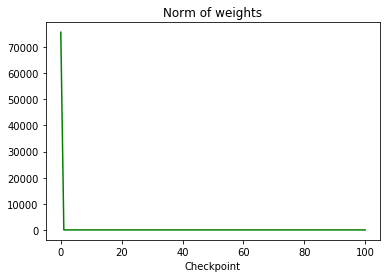

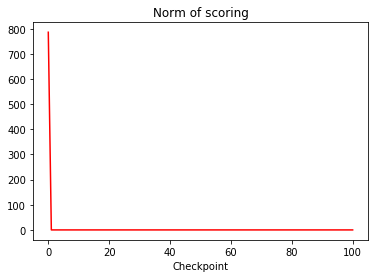

[OrderedDict([('cell.L_list.0', tensor([[ 1.1071,  0.3395, -0.3342,  ..., -0.5628,  0.0928, -0.0465],
        [-0.7941, -0.3529,  0.5976,  ..., -1.7932, -1.0681, -1.0499],
        [-0.5358,  1.4441,  0.3963,  ..., -0.5236,  0.0697,  0.7906],
        ...,
        [-0.5114, -1.0020,  0.9189,  ..., -0.1468,  1.7154, -0.2107],
        [-0.5820,  0.6214, -0.1091,  ...,  0.3336, -1.1833, -0.8424],
        [ 0.5084, -0.7056, -0.7946,  ...,  1.6762,  0.8532,  0.6705]])), ('cell.L_list.1', tensor([[ 1.2809,  0.0675,  1.1178,  ...,  1.3025, -1.4711,  0.1965],
        [-0.0884, -0.1634, -0.4457,  ..., -0.5817, -0.8095,  1.0752],
        [ 1.0457, -0.0755, -1.1584,  ..., -0.8380, -1.1248, -0.6948],
        ...,
        [-1.1059,  0.9825,  0.1873,  ...,  0.9848, -0.5913, -0.8245],
        [-1.2329, -1.8308,  1.3218,  ...,  2.0606, -0.2467,  0.2580],
        [ 1.0174, -0.7595, -0.1544,  ..., -0.1030,  0.6048, -0.1190]])), ('cell.L_list.2', tensor([[-0.9318,  0.9861, -1.9774,  ...,  0.0240,  0.6762, 

In [33]:
# Display weight magnitudes

epochs = params['epochs']
checkpoints = []
for file in os.listdir(dirname):
    if '.pt' in file:
        checkpoints.append(file)

checkpoints = [torch.load(dirname + '/' + checkpoint) for checkpoint in sorted(checkpoints)]
magnitudes = np.zeros(len(checkpoints))
scoring = np.zeros(len(checkpoints))
        
for weights in checkpoints:
    for weight in weights:
        magnitudes[i] += weights[weight].norm()
        if 'scoring' in weight:
            scoring[i] += weights[weight].norm()
        

plt.figure()
plt.plot(range(len(magnitudes)), magnitudes, 'g')
plt.title('Norm of weights')
plt.xlabel('Checkpoint')
plt.show()

plt.figure()
plt.plot(range(len(scoring)), scoring, 'r')
plt.title('Norm of scoring')
plt.xlabel('Checkpoint')
plt.show()

print(checkpoints)

In [ ]:
# Show 5 different structures from training

structures = []
with open(dirname+'/structure.txt') as f:
    lines = f.readlines()
    for line in lines:
        if line != '\n':
            structures.append(line)
            
    spacing = 1000
#     for i in range(0, N_iters, spacing):
# #         print('Iteration', i)
# #         print(structures[i])
#         print()
    
    print('Final structure')
    print(structures[-1])

In [ ]:
# Show GRU structures
import ast
from tqdm import tqdm

best = None
fewest_differences = np.Inf
best_iter = 0
for i, structure in enumerate(structures):
    structure = ast.literal_eval(structure)
    if structure_is_gru(structure):
        diffs = n_differences(structure, GRU_STRUCTURE)
        if diffs < fewest_differences:
            best = structure
            fewest_differences = diffs
            best_iter = i

            
if best is None:
    print('No GRU structures found.')
else:
    print('Best structure (%d differences from GRU) achieved on iteration %d' % (fewest_differences, best_iter))
    pprint(best)

In [ ]:
# Look at spikes

start = int(1e5)
loss4 = losses[:, 3]
spikes = np.argsort(loss4[start:])[::-1] + start
rows = spikes * 2 + 1
for row, spike in zip(rows, spikes):
    print(row-2, loss4[spike-1])
    print(row, loss4[spike])
    print(row+2, loss4[spike+1])
